# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer


import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm_n

import os

C:\Users\babarohitk\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (500000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
filtered_data['Score'].value_counts()

1    421777
0     78223
Name: Score, dtype: int64

In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(348262, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.6524

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
print(final['Score'].value_counts())
final.head()

(348260, 10)
1    293516
0     54744
Name: Score, dtype: int64


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138702,150520,0006641040,ADBFSA9KTQANE,"James L. Hammock ""Pucks Buddy""",0,0,1,1256688000,Great Gift,This book was purchased as a birthday gift for...
138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,1,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books..."
138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,0,1129507200,awesome book poor size,This is one of the best children's books ever ...
138692,150510,0006641040,AM1MNZMYMS7D8,Dr. Joshua Grossman,0,0,1,1348358400,Professional Mentoring,TITLE: Chicken Soup with Rice<br />AUTHOR: Mau...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...


### Balancing the Dataset 

In [15]:
# Separating Negative and positive scores
df_pos=final[final.Score == 1]
df_neg=final[final.Score == 0]

In [16]:
# Sampling 25k rows each for Class label 0 and 1
df_pos = df_pos.sample(n=25000, random_state=0)
df_neg = df_neg.sample(n=25000, random_state=0)

In [17]:
final = pd.concat([df_pos,df_neg], ignore_index=True)

In [18]:
final['Score'].value_counts()

1    25000
0    25000
Name: Score, dtype: int64

In [19]:
final = final.sample(frac=1,random_state=0).reset_index(drop=True)

In [20]:
final.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,110274,B001EPQ73O,A2TYA2EM8UWYG7,Kristen,0,0,1,1302048000,Very Good Tea,"I actually had never tried Genmaicha before, b..."
1,166817,B00269K1FC,A3D6OI36USYOU1,Ghenghis,0,0,1,1341532800,Very good and very very hot!,But thats what you would expect and thats exac...
2,160088,B000HDJXH6,A2E4CI0DLIEUU3,Lindsaylouella,0,1,0,1306454400,Definitely NOT for me!,"I am not allergic to anything except lactose, ..."
3,251416,B004H3N2LU,A9E4M8BOZA0GW,gambowler,0,0,0,1296172800,It's instant coffee,I wish I would have read these reviews before ...
4,239761,B003120YQY,A38L2HENELPDEB,R. Bleicher,2,2,0,1323216000,How much caffeine?,Buyer beware. Notice how carefully worded the...
5,276622,B000EIVM8C,A143C14PMOHCU0,AM,0,4,0,1300060800,GROSS!!!,This tastes HORRIBLE!!! COMPLETE waste of MONE...
6,424611,B002HFPW6I,A2YR0TP4FOB316,retired consumer 999,4,6,0,1283558400,Made in China,"If I had known they come from China, I would h..."
7,444820,B000812K0O,AUVL1XFO0I312,Jeffrey Anderson,0,0,1,1168300800,Additive,These are great. I'm in training and they're a...
8,136194,B000EPOC1Y,AUFO5GFCYNRD5,Kevin Harper,1,3,0,1203465600,disappointing taste,I like the fact that the Mi-Del cookies are lo...
9,247278,B000EOXQS0,AJOU4XX7D2PM5,"Mr. Kcebraz ""Paul""",4,5,0,1278028800,Salty Soup,"To much salt, can't drink the broth. Most con..."


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [21]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I actually had never tried Genmaicha before, but a friend recommended this to me when my fiance and I received a cast iron teapot for Christmas. Although very different than the loose teas we have purchased so far, I love it. The gives it a very distinct and satisfying flavor. We have enjoyed it almost on a nightly basis since receiving it.
I love these Ghiradelli Chocolate Cocoa mixes.  It's especially good to mix into vanilla tapioca!
In general, the quality of the rice was quite good, but had one package that was not sealed properly and had gone bad.
I was hyped to get this childhood favorite on my doorstep until one by one as I started to open them I found that they had mostly melted. The sour powdery coat on these candies isn't as good when its mixed in with the deformed candy :( doesn't seem they are being stored at the correct temperature. I just expect more when I am paying so much for a pound of candy....


In [22]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I actually had never tried Genmaicha before, but a friend recommended this to me when my fiance and I received a cast iron teapot for Christmas. Although very different than the loose teas we have purchased so far, I love it. The gives it a very distinct and satisfying flavor. We have enjoyed it almost on a nightly basis since receiving it.


In [23]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I actually had never tried Genmaicha before, but a friend recommended this to me when my fiance and I received a cast iron teapot for Christmas. Although very different than the loose teas we have purchased so far, I love it. The gives it a very distinct and satisfying flavor. We have enjoyed it almost on a nightly basis since receiving it.
I love these Ghiradelli Chocolate Cocoa mixes.  It's especially good to mix into vanilla tapioca!
In general, the quality of the rice was quite good, but had one package that was not sealed properly and had gone bad.
I was hyped to get this childhood favorite on my doorstep until one by one as I started to open them I found that they had mostly melted. The sour powdery coat on these candies isn't as good when its mixed in with the deformed candy :( doesn't seem they are being stored at the correct temperature. I just expect more when I am paying so much for a pound of candy....


In [24]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    #To remove repetetive words like aa bbb ccc 
    phrase = re.sub(r"(.)\1{2,}","", phrase)
    return phrase

In [25]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

In general, the quality of the rice was quite good, but had one package that was not sealed properly and had gone bad.


In [26]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I actually had never tried Genmaicha before, but a friend recommended this to me when my fiance and I received a cast iron teapot for Christmas. Although very different than the loose teas we have purchased so far, I love it. The gives it a very distinct and satisfying flavor. We have enjoyed it almost on a nightly basis since receiving it.


In [27]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

In general the quality of the rice was quite good but had one package that was not sealed properly and had gone bad 


In [28]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [29]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = re.sub(r"(.)\1{2,}","", sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:43<00:00, 1147.34it/s]


In [30]:
#number of reviews
np.shape(preprocessed_reviews)

(50000,)

In [31]:
preprocessed_reviews[150]

'whole line chocolate best sugar free chocolate ever tasted service great delivered last order christmas day'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [32]:
# Combining all the above stundents 
preprocessed_reviews_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = re.sub(r"(.)\1{2,}","", sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews_summary.append(sentance.strip())

 40%|█████████████████████████████▋                                            | 20040/50000 [00:08<00:12, 2359.17it/s]C:\Users\babarohitk\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 67%|█████████████████████████████████████████████████▏                        | 33259/50000 [00:14<00:06, 2493.35it/s]C:\Users\babarohitk\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 70%|███████████████████████████████████████████████████▊                      | 35002/50000 [00:15<00:06, 2412.57it/s]C:\Users\babarohitk\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass t

In [33]:
preprocessed_reviews_summary[150]

'best sugar free chocolate'

# [4] Featurization

## [4.1] BAG OF WORDS

In [34]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaah', 'aachen', 'aafco', 'aafcoa', 'aamazon', 'aap', 'aarrgg', 'ab', 'aback']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (50000, 48371)
the number of unique words  48371


## [4.2] Bi-Grams and n-Grams.

In [35]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (50000, 500)
the number of unique words including both unigrams and bigrams  500


## [4.3] TF-IDF

In [36]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=500)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'absolutely', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almost', 'also', 'although']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (50000, 500)
the number of unique words including both unigrams and bigrams  500


## [4.4] Word2Vec

In [37]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [38]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8735561966896057), ('wonderful', 0.8674764037132263), ('awesome', 0.8395775556564331), ('excellent', 0.8305661678314209), ('good', 0.8079215288162231), ('amazing', 0.7782161831855774), ('perfect', 0.7694277763366699), ('terrific', 0.7357414364814758), ('nice', 0.7235321402549744), ('incredible', 0.7187521457672119)]
[('nastiest', 0.8019813299179077), ('best', 0.7535408735275269), ('horrid', 0.6662178039550781), ('worse', 0.6468880772590637), ('vile', 0.6366452574729919), ('disgusting', 0.6293272376060486), ('grossest', 0.6237624287605286), ('closest', 0.6178014278411865), ('terrible', 0.6096993684768677), ('smoothest', 0.6002680659294128)]


In [39]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  14090
sample words  ['actually', 'never', 'tried', 'genmaicha', 'friend', 'recommended', 'fiance', 'received', 'cast', 'iron', 'teapot', 'christmas', 'although', 'different', 'loose', 'teas', 'purchased', 'far', 'love', 'gives', 'distinct', 'satisfying', 'flavor', 'enjoyed', 'almost', 'nightly', 'basis', 'since', 'receiving', 'thats', 'would', 'expect', 'exactly', 'want', 'marinade', 'not', 'exaggerating', 'heat', 'level', 'stuff', 'probably', 'tolerate', 'front', 'line', 'way', 'back', 'perfectly', 'spices', 'make', 'either']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [40]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm_n(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))


50000
50


#### [4.4.1.2] TFIDF weighted W2v

In [41]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm_n(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying KNN brute force

In [43]:
# Imports
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [63]:
# Fuction to compute best K value using BruteKNN
def BruteModel(final_X_tr, Y_tr,final_X_test,Y_test,final_X_cv,Y_cv):
    Roc_tr=[]
    Roc_cv=[]
    k_value=[]
    max_auc_score=0
    K_best=0
    for i in range(1,100,4):
        
        #Fitting the model on Training data
        knn = KNeighborsClassifier(algorithm='brute',metric='minkowski',n_neighbors=i,n_jobs=-1)
        knn.fit(final_X_tr, Y_tr)

        #Predicting the Probability Estimates on Cross Validation data
        pred_cv = knn.predict_proba(final_X_cv)
        pred_cv=(pred_cv)[:,1]
        Roc_cv.append(roc_auc_score(Y_cv,pred_cv))
    
        #Predict the Probability Estimates on the Training data
        pred_tr = knn.predict_proba(final_X_tr)
        pred_tr=(pred_tr)[:,1]
        Roc_tr.append(roc_auc_score(Y_tr,pred_tr))
        k_value.append(i)
    
        #Store best K which has highest AUC score
        if roc_auc_score(Y_cv,pred_cv)>max_auc_score:
            k_best=i
            max_auc_score=roc_auc_score(Y_cv,pred_cv)
    K=k_best
    AUC=max_auc_score
    
    # Plotting AUC vs K graph of CV and Training Data
    plt.plot(k_value,Roc_cv ,label="AUC(cv)")
    plt.plot(k_value,Roc_tr,label="AUC(train)")
    plt.legend()
    plt.title('AUC vs K')
    plt.xlabel('K')
    plt.ylabel('AUC')
    plt.show()
    print("Best k value = ",K)        
    print("Best Auc value = ",AUC)
    print("="*36)
    
    #Training the model with K(Best) 
    knn = KNeighborsClassifier(algorithm='brute',metric='minkowski',n_neighbors=k_best,n_jobs=-1)
    knn.fit(final_X_tr, Y_tr)
    #predicting probability on Test data
    pred_test = knn.predict_proba(final_X_test)
    pred_test=(pred_test)[:,1]
    #predicting probablity of Training data
    pred_tr = knn.predict_proba(final_X_tr)
    pred_tr=(pred_tr)[:,1]
    
    #fpr and tpr on Traing and Test Data
    fpr, tpr, threshold = metrics.roc_curve(Y_test, pred_test)
    fpr1, tpr1, threshold1 = metrics.roc_curve(Y_tr, pred_tr)
    
    #Plotting Roc Curve
    plt.plot(fpr,tpr ,label="characterstics on Test data")
    plt.plot(fpr1,tpr1 ,label="characterstics on Train data")
    plt.legend()
    plt.title('ROC on best K')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()
    
    #Confusion Matrix
    predic=knn.predict(final_X_test)
    conf_mat = confusion_matrix(Y_test, predic)
    
    #Confusion Matrix Heatmap
    class_label = ["-", "+"]
    df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
    sns.heatmap(df, annot = True,fmt="d",cmap="Spectral")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    return K,AUC,predic


In [64]:
# Fuction to compute best K value using kd_tree
def KDtreeModel(final_X_tr, Y_tr,final_X_test,Y_test,final_X_cv,Y_cv):
    Roc_tr=[]
    Roc_cv=[]
    k_value=[]
    max_auc_score=0
    K_best=0
    for i in range(1,100,4):
        
        #Fitting the model on train data
        knn = KNeighborsClassifier(algorithm='kd_tree',metric='minkowski',n_neighbors=i,n_jobs=-1)
        knn.fit(final_X_tr, Y_tr)

        #Predict the Probability Estimates on the Cross Validation data
        pred_cv = knn.predict_proba(final_X_cv)
        pred_cv=(pred_cv)[:,1]
        Roc_cv.append(roc_auc_score(Y_cv,pred_cv))
    
        #Predict the Probability Estimates on the Training data
        pred_tr = knn.predict_proba(final_X_tr)
        pred_tr=(pred_tr)[:,1]
        Roc_tr.append(roc_auc_score(Y_tr,pred_tr))
        k_value.append(i)
    
        #Store best K which has highest AUC score
        if roc_auc_score(Y_cv,pred_cv)>max_auc_score:
            k_best=i
            max_auc_score=roc_auc_score(Y_cv,pred_cv)
    K=k_best
    AUC=max_auc_score
    
    # Plotting AUC vs K graph of CV and Training Data
    plt.plot(k_value,Roc_cv ,label="AUC(cv)")
    plt.plot(k_value,Roc_tr,label="AUC(train)")
    plt.legend()
    plt.title('AUC vs K')
    plt.xlabel('K')
    plt.ylabel('AUC')
    plt.show()
    print("Best k value = ",K)        
    print("Best Auc value = ",AUC)
    print("="*36)
    
    #Training the model with K(Best) 
    knn = KNeighborsClassifier(algorithm='kd_tree',metric='minkowski',n_neighbors=K,n_jobs=-1)
    knn.fit(final_X_tr, Y_tr)
    #predicting probability on Test data
    pred_test = knn.predict_proba(final_X_test)
    pred_test=(pred_test)[:,1]
    #predicting probablity of Training data
    pred_tr = knn.predict_proba(final_X_tr)
    pred_tr=(pred_tr)[:,1]
    
    #fpr and tpr on Traing and Test Data
    fpr, tpr, threshold = metrics.roc_curve(Y_test, pred_test)
    fpr1, tpr1, threshold1 = metrics.roc_curve(Y_tr, pred_tr)
    
    #Plotting Roc Curve
    plt.plot(fpr,tpr ,label="characterstics on Test data")
    plt.plot(fpr1,tpr1 ,label="characterstics on Train data")
    plt.legend()
    plt.title('ROC on best K')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()
    
    #Confusion Matrix
    predic=knn.predict(final_X_test)
    conf_mat = confusion_matrix(Y_test, predic)
    
    #Confusion Matrix Heatmap
    class_label = ["--", "+"]
    df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
    sns.heatmap(df, annot = True,fmt="d",cmap="RdYlGn")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    return K,AUC,predic

In [47]:
def avgw2v(X_tr):
    list_of_sentance_tr=[]
    for sentance in X_tr:
        list_of_sentance_tr.append(sentance.split())
    final_X_tr = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm_n(list_of_sentance_tr): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        final_X_tr.append(sent_vec)
    return final_X_tr

def tfw2v(X_tr,tfidf_feat):
    list_of_sentance_tr=[]
    for sentance in X_tr:
        list_of_sentance_tr.append(sentance.split())
    final_X_tr = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm_n(list_of_sentance_tr): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        final_X_tr.append(sent_vec)
        row += 1
    return final_X_tr

In [48]:
#Spliting Dataset to (Train-CrossValidation)70%,(Test)30%
X=preprocessed_reviews
X=np.array(X)
Y = np.array(final['Score'])

In [49]:
#We are Only considering 18K(40%) reviews out of 46k for less run time.
X_1, X_tr, Y_1, Y_tr = train_test_split(X, Y, test_size=0.4, random_state=0,stratify = Y )
X_tr, X_cv, Y_tr, Y_cv = train_test_split(X_tr, Y_tr, test_size=0.4,random_state=0,stratify = Y_tr)
X_cv, X_test, Y_cv, Y_test = train_test_split(X_cv, Y_cv, test_size=0.4,random_state=0,stratify = Y_cv)

In [50]:
unique_elements, counts_elements = np.unique(Y_tr, return_counts=True)
print("Value counts of class labels in Train data set:")
print(np.asarray((unique_elements, counts_elements)))

Value counts of class labels in Train data set:
[[   0    1]
 [6000 6000]]


### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [51]:
#Text to Bag of words(Vectors)
count_vect = CountVectorizer()
final_X_tr=count_vect.fit_transform(X_tr)
final_X_test=count_vect.transform(X_test)
final_X_cv=count_vect.transform(X_cv)

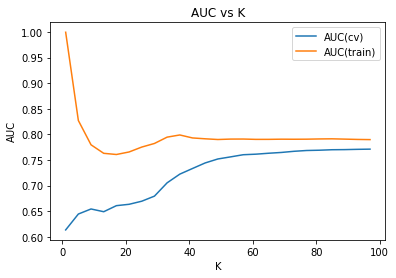

Best k value =  97
Best Auc value =  0.7711753472222223


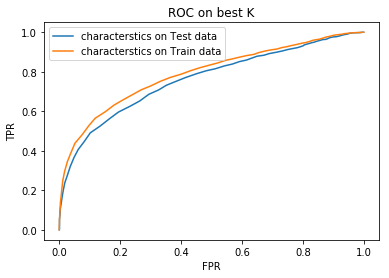

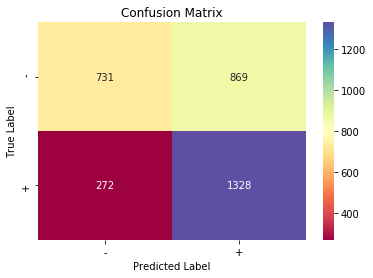

Wall time: 5min 20s


In [52]:
%%time
k1,auc1,predic=BruteModel(final_X_tr, Y_tr,final_X_test,Y_test,final_X_cv,Y_cv)

In [53]:
print(classification_report(Y_test, predic))

             precision    recall  f1-score   support

          0       0.73      0.46      0.56      1600
          1       0.60      0.83      0.70      1600

avg / total       0.67      0.64      0.63      3200



### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

In [54]:
#Converting Reviews to tf_idf_vec
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10,max_features = 500 )
final_X_tr=tf_idf_vect.fit_transform(X_tr)
final_X_test=tf_idf_vect.transform(X_test)
final_X_cv=tf_idf_vect.transform(X_cv)

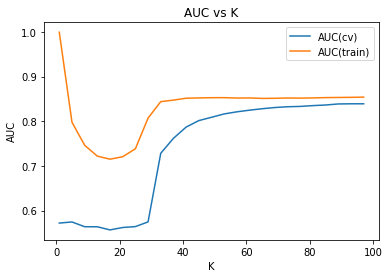

Best k value =  93
Best Auc value =  0.8390716145833333


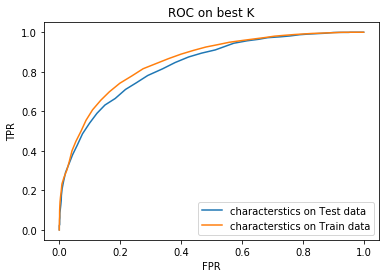

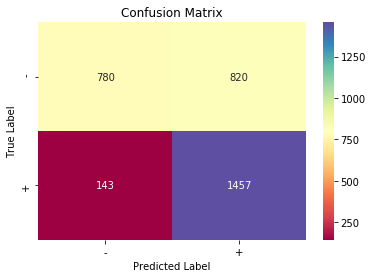

Wall time: 4min 45s


In [55]:
%%time
k2,auc2,predic=BruteModel(final_X_tr, Y_tr,final_X_test,Y_test,final_X_cv,Y_cv)

In [56]:
print(classification_report(Y_test, predic))

             precision    recall  f1-score   support

          0       0.85      0.49      0.62      1600
          1       0.64      0.91      0.75      1600

avg / total       0.74      0.70      0.68      3200



### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [57]:
final_X_tr_avgw2v = avgw2v(X_tr)
final_X_cv_avgw2v = avgw2v(X_cv)
final_X_test_avgw2v = avgw2v(X_test)

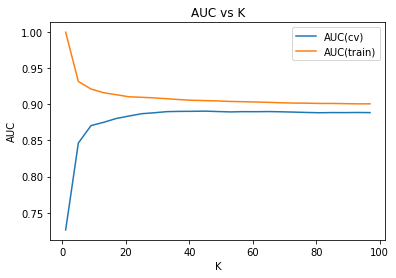

Best k value =  45
Best Auc value =  0.8903137152777778


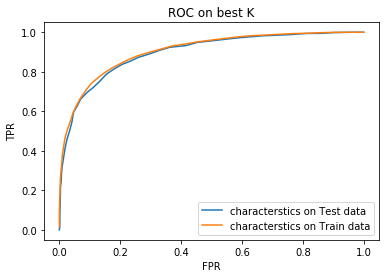

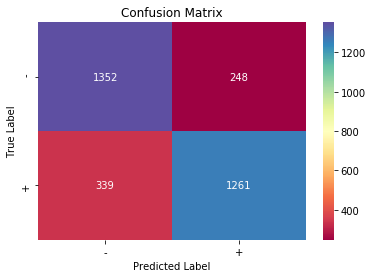

Wall time: 2min 51s


In [58]:
%%time
k3,auc3,predic=BruteModel(final_X_tr_avgw2v, Y_tr,final_X_test_avgw2v,Y_test,final_X_cv_avgw2v,Y_cv)

In [59]:
print(classification_report(Y_test, predic))

             precision    recall  f1-score   support

          0       0.80      0.84      0.82      1600
          1       0.84      0.79      0.81      1600

avg / total       0.82      0.82      0.82      3200



### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [60]:
# tfidf Words
tfidf_feat = model.get_feature_names() 

final_X_tr_tfw2v = tfw2v(X_tr,tfidf_feat)
final_X_cv_tfw2v = tfw2v(X_cv,tfidf_feat)
final_X_test_tfw2v = tfw2v(X_test,tfidf_feat)

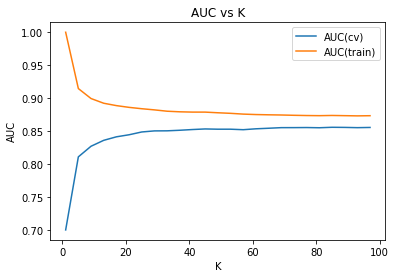

Best k value =  85
Best Auc value =  0.8557075520833334


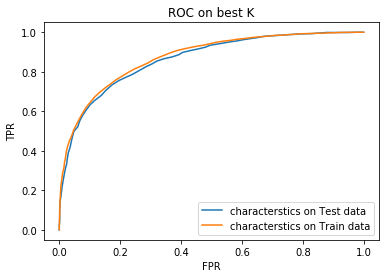

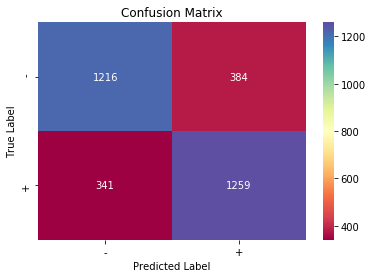

Wall time: 2min 41s


In [61]:
%%time
k4,auc4,predic=BruteModel(final_X_tr_tfw2v, Y_tr,final_X_test_tfw2v,Y_test,final_X_cv_tfw2v,Y_cv)

In [62]:
print(classification_report(Y_test, predic))

             precision    recall  f1-score   support

          0       0.78      0.76      0.77      1600
          1       0.77      0.79      0.78      1600

avg / total       0.77      0.77      0.77      3200



## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [65]:
#Reviews to Bag of words
count_vect = CountVectorizer(min_df=10, max_features=500)
final_X_tr=count_vect.fit_transform(X_tr)
final_X_test=count_vect.transform(X_test)
final_X_cv=count_vect.transform(X_cv)

#Sparse to Dense matrices
final_X_tr=final_X_tr.toarray()
final_X_test=final_X_test.toarray()
final_X_cv=final_X_cv.toarray()

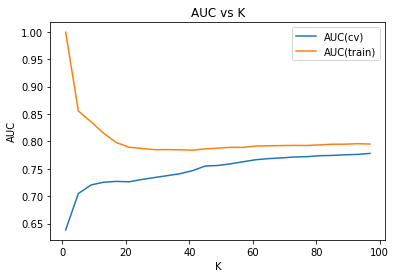

Best k value =  97
Best Auc value =  0.7780827256944445


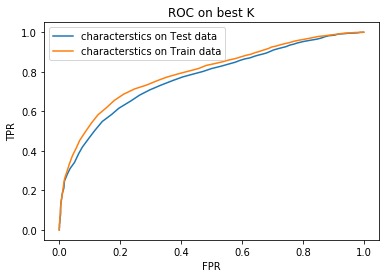

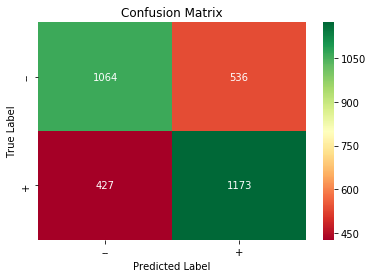

Wall time: 41min 17s


In [66]:
%%time
k5,auc5,predic=KDtreeModel(final_X_tr, Y_tr,final_X_test,Y_test,final_X_cv,Y_cv)

In [67]:
print(classification_report(Y_test, predic))

             precision    recall  f1-score   support

          0       0.71      0.67      0.69      1600
          1       0.69      0.73      0.71      1600

avg / total       0.70      0.70      0.70      3200



### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [68]:
%%time
#Reviews to tf_idf_vec
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10 , max_features=500)
final_X_tr=tf_idf_vect.fit_transform(X_tr)
final_X_test=tf_idf_vect.transform(X_test)
final_X_cv=tf_idf_vect.transform(X_cv)

#Sparse to Dense matrices
final_X_tr=final_X_tr.toarray()
final_X_test=final_X_test.toarray()
final_X_cv=final_X_cv.toarray()

Wall time: 4.21 s


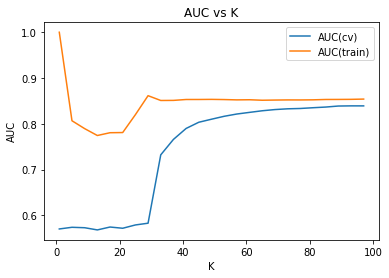

Best k value =  93
Best Auc value =  0.8388835069444444


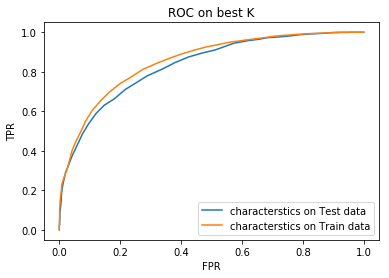

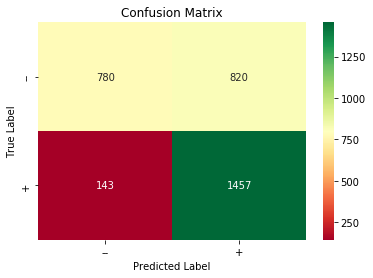

Wall time: 41min 20s


In [69]:
%%time
k6,auc6,predic=KDtreeModel(final_X_tr, Y_tr,final_X_test,Y_test,final_X_cv,Y_cv)

In [70]:
%%time
print(classification_report(Y_test, predic))

             precision    recall  f1-score   support

          0       0.85      0.49      0.62      1600
          1       0.64      0.91      0.75      1600

avg / total       0.74      0.70      0.68      3200

Wall time: 7.99 ms


### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

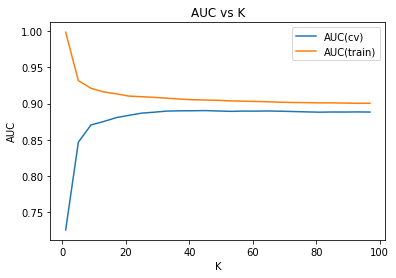

Best k value =  45
Best Auc value =  0.8903137152777778


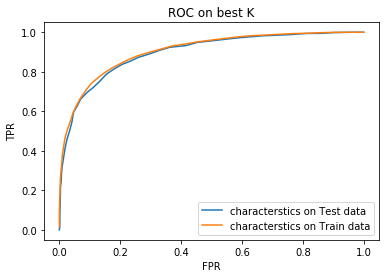

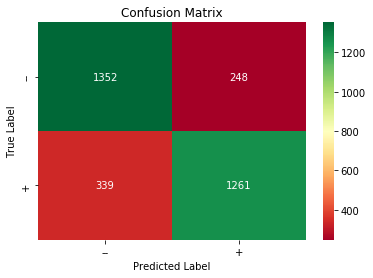

Wall time: 6min 16s


In [71]:
%%time
k7,auc7,predic=KDtreeModel(final_X_tr_avgw2v, Y_tr,final_X_test_avgw2v,Y_test,final_X_cv_avgw2v,Y_cv)

In [72]:
%%time
print(classification_report(Y_test, predic))

             precision    recall  f1-score   support

          0       0.80      0.84      0.82      1600
          1       0.84      0.79      0.81      1600

avg / total       0.82      0.82      0.82      3200

Wall time: 8.99 ms


### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

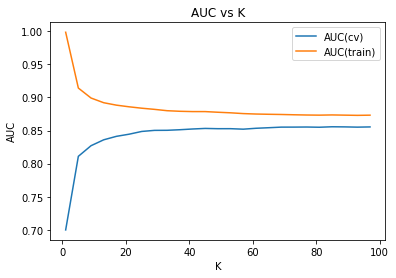

Best k value =  85
Best Auc value =  0.8556972222222222


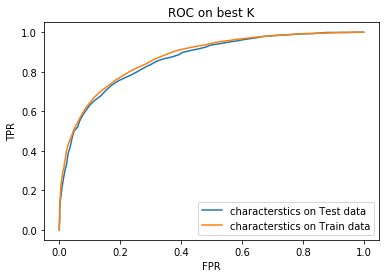

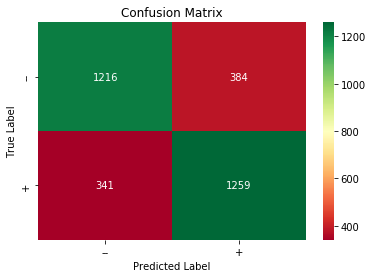

Wall time: 5min 54s


In [73]:
%%time
k8,auc8,predic=KDtreeModel(final_X_tr_tfw2v, Y_tr,final_X_test_tfw2v,Y_test,final_X_cv_tfw2v,Y_cv)

In [74]:
print(classification_report(Y_test, predic))

             precision    recall  f1-score   support

          0       0.78      0.76      0.77      1600
          1       0.77      0.79      0.78      1600

avg / total       0.77      0.77      0.77      3200



# [6] Conclusions

In [75]:
%%time
from prettytable import PrettyTable    
Table = PrettyTable()
Table.field_names = ["Vector Type", "Method", "Optimal K", "AUC"]
Table.add_row(["BOW","Brute",k1,auc1])
Table.add_row(["TF-IDF","Brute",k2,auc2])
Table.add_row(["Avg-W2V","Brute",k3,auc3])
Table.add_row(["TF-IDF W2V","Brute",k4,auc4])
Table.add_row(["BOW","k_d tree",k5,auc5])
Table.add_row(["TF-IDF","k_d tree",k6,auc6])
Table.add_row(["Avg-W2V","k_d tree",k7,auc7])
Table.add_row(["TF-IDF W2V","k_d tree",k8,auc8])
print(Table)

+-------------+----------+-----------+--------------------+
| Vector Type |  Method  | Optimal K |        AUC         |
+-------------+----------+-----------+--------------------+
|     BOW     |  Brute   |     97    | 0.7711753472222223 |
|    TF-IDF   |  Brute   |     93    | 0.8390716145833333 |
|   Avg-W2V   |  Brute   |     45    | 0.8903137152777778 |
|  TF-IDF W2V |  Brute   |     85    | 0.8557075520833334 |
|     BOW     | k_d tree |     97    | 0.7780827256944445 |
|    TF-IDF   | k_d tree |     93    | 0.8388835069444444 |
|   Avg-W2V   | k_d tree |     45    | 0.8903137152777778 |
|  TF-IDF W2V | k_d tree |     85    | 0.8556972222222222 |
+-------------+----------+-----------+--------------------+
Wall time: 197 ms
